<a href="https://colab.research.google.com/github/Julialunna/Fed-DP-PSO/blob/main/Fed_DP_PSO_FEMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install flwr
!pip install flwr-datasets
!pip install datasets

In [3]:
!pip install opacus

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset, TensorDataset
from torchvision import datasets, transforms
import torch.nn.functional as F
import copy
import random
import torchvision
import torchvision.models as models

import math
import numpy as np
from collections import OrderedDict

from flwr_datasets.partitioner import DirichletPartitioner, IidPartitioner
from flwr_datasets import FederatedDataset
from datasets import load_dataset,  Dataset as HFDataset
from flwr_datasets.partitioner import DirichletPartitioner
from flwr_datasets.visualization import plot_label_distributions


from opacus import PrivacyEngine
from opacus.utils.batch_memory_manager import BatchMemoryManager
from opacus.accountants.utils import get_noise_multiplier
from opacus.accountants import RDPAccountant

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class FEMNIST_CNN(nn.Module):
    def __init__(self):
        super(FEMNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)   # (28x28) → (28x28)
        self.pool1 = nn.MaxPool2d(2, 2)                           # (28x28) → (14x14)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)  # (14x14) → (14x14)
        self.pool2 = nn.MaxPool2d(2, 2)                           # (14x14) → (7x7)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 62)  # FEMNIST tem 62 classes

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)  # Redimensiona o tensor para CNN
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.dropout(x)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [16]:
# Definições dos hiperparâmetros
NUM_CLIENTES = 5
NUM_PARTICULAS = 3
NUM_RODADAS = 1

#INERCIA, C1, C2 = 0.8, 1.5,  1.9
INERCIA, C1, C2 = 0.7, 1.4, 1.4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 240

print(f'training on {DEVICE}')

training on cuda


90


/usr/local/lib/python3.11/dist-packages/flwr_datasets/metrics/utils.py:130: UserWarning: The verbose names can not be established. The column specified by 'column_name' needs to be of type 'ClassLabel' to create a verbose names. The available names will used.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


(2, 3.725837469100952)
(4, 3.7887137844448997)
(0, 3.789492885271708)
(3, 3.8925021489461265)
(1, 3.973392685254415)
epsilon: 4.994389288556934
Rodada 1/1: Cliente 2 enviou os pesos!
Erro Global Atualizado: 3.7258
Epsilon 10 desbalanceado extremo 
Teste -> Perda:  3.7258, Acurácia:  25.6100%

Acurácia média:  0.26
Treinamento Federado Finalizado!


TypeError: treinar_federado() missing 8 required positional arguments: 'clientes', 'criterio', 'num_rodadas', 'INERCIA', 'C1', 'C2', 'testloader', and 'validationloader'

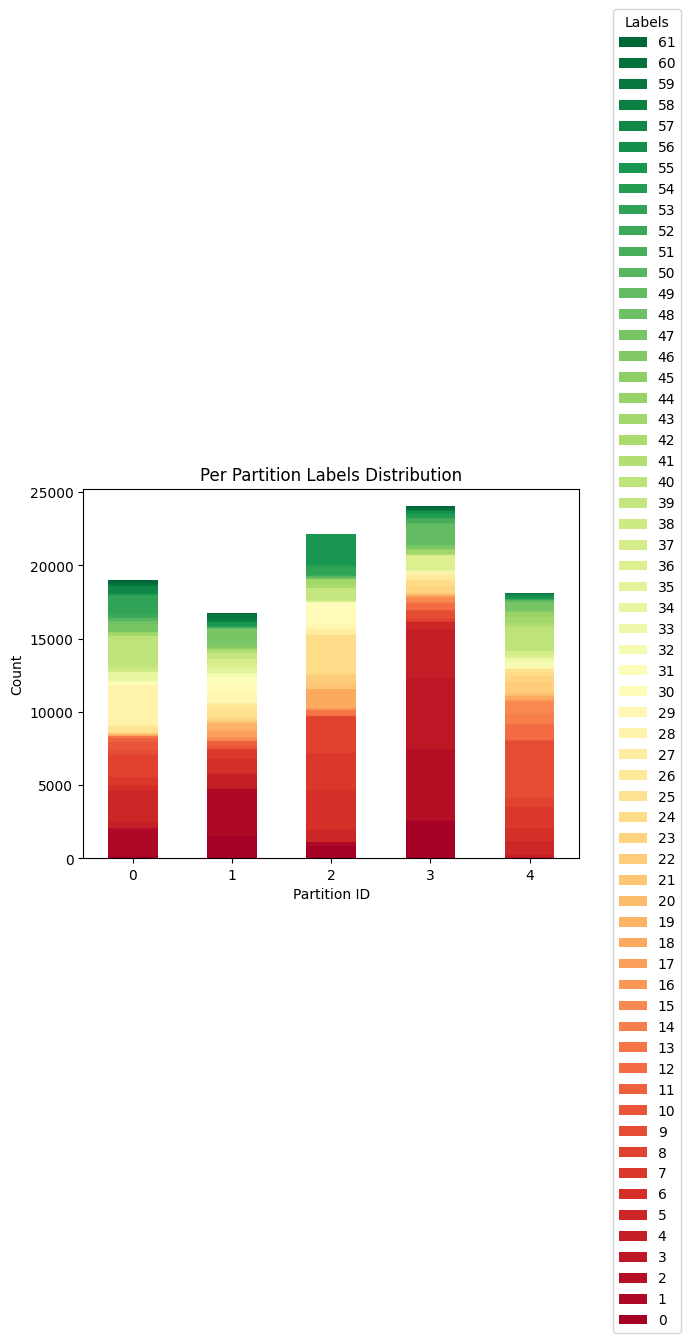

In [17]:
ALPHA = 0.3
# numero = 42
# numero = 88
numero = 90
# numero = 36
print(numero)
random.seed(numero)
torch.manual_seed(numero)
torch.cuda.manual_seed(numero)

# Criando o modelo global
modelo_global = FEMNIST_CNN().to(DEVICE)
criterio = nn.CrossEntropyLoss(label_smoothing=0.1)
# criterio = nn.CrossEntropyLoss()

class Particula:
    def __init__(self, particle_id, modelo_cliente, teste):
        self.particle_id = particle_id
        # self.pesos = copy.deepcopy(modelo_cliente.state_dict())
        self.pesos = {f"_module.{key}": value.clone() for key, value in modelo_cliente.state_dict().items()}
        self.device = next(modelo_cliente.parameters()).device
        self.teste = teste

        # Adiciona ruído leve nos pesos para quebrar simetria inicial
        for name in self.pesos:
            self.pesos[name] += 0.01 * torch.randn_like(self.pesos[name])

        self.melhor_pesos = copy.deepcopy(self.pesos)
        self.melhor_erro = float('inf')
        self.velocidade = {name: torch.zeros_like(param) for name, param in self.pesos.items()}


    def atualizar_pso(self, global_best_pesos, INERCIA, C1, C2):
        MAX_VELOCITY = 0.1  # Limite para evitar oscilações grandes
        if(round == 0):
          global_best_weights_adjusteds = {f"_module.{key}": value for key, value in global_best_pesos.items()}
        for name in self.pesos:
            local_rand = random.random()
            global_rand = random.random()
            self.velocidade[name] = (
                INERCIA * self.velocidade[name]
                + C1 * local_rand * (self.melhor_pesos[name] - self.pesos[name])
                + C2 * global_rand * (global_best_pesos[name] - self.pesos[name])
            )

            # Clipping da velocidade
            self.velocidade[name] = torch.clamp(self.velocidade[name], -MAX_VELOCITY, MAX_VELOCITY)

            # Atualiza os pesos com a nova velocidade
            self.pesos[name] += self.velocidade[name]

    def avaliar_perda(self, modelo_cliente, criterio):
        modelo_cliente.load_state_dict(self.pesos)
        modelo_cliente.eval()
        total_loss = 0
        device = next(modelo_cliente.parameters()).device

        with torch.no_grad():
            for inputs, labels in self.teste:
                inputs, labels =  inputs.to(self.device), labels.to(self.device)
                outputs = modelo_cliente(inputs)
                loss = criterio(outputs, labels)
                total_loss += loss.item()


        return total_loss / len(self.teste)



class Cliente:
    def __init__(self, cliente_id, modelo_global, dados, test, num_particulas):
        self.cliente_id = cliente_id
        self.modelo = copy.deepcopy(modelo_global)  # Cada cliente tem seu próprio modelo
        self.dados = dados
        self.test = test
        self.num_particulas = num_particulas
        self.particulas = []
        self.melhor_particula = None
        self.inicializar_particulas(num_particulas, test)
        self.optimizer = optim.Adam(self.modelo.parameters(), lr=0.005, weight_decay=1e-5)

    def inicializar_particulas(self, num_particulas, test):
        """Cria um conjunto de partículas associadas ao cliente."""
        self.particulas = [Particula(i, self.modelo, test) for i in range(num_particulas)]

    def treinar_com_pso(self, INERCIA, C1, C2, global_best_pesos, criterio):
        """Treina as partículas usando PSO e atualiza a melhor partícula local."""

        for particula in self.particulas:
            particula.atualizar_pso(global_best_pesos, INERCIA, C1, C2)
            erro = particula.avaliar_perda(self.modelo, criterio)
            if erro < particula.melhor_erro:
                particula.melhor_erro = erro
                particula.melhor_pesos = copy.deepcopy(particula.pesos)

        self.selecionar_melhor_particula()
        # modelo_global.load_state_dict(self.melhor_particula.pesos)

    def refinar_com_adam(self, criterio):
        """Refina os pesos da melhor partícula usando Adam."""
        self.modelo.load_state_dict(self.melhor_particula.melhor_pesos)
        # self.modelo.load_state_dict(modelo_global.state_dict())
        device = next(self.modelo.parameters()).device

        self.modelo.train()
        for i in range(1):
          with BatchMemoryManager(data_loader=self.dados, max_physical_batch_size=BATCH_SIZE, optimizer=self.optimizer) as new_data_loader:
            for batch in new_data_loader:
                inputs, labels = batch["image"].to(device), batch["label"].to(device)
                self.optimizer.zero_grad()
                outputs = self.modelo(inputs)
                loss = criterio(outputs, labels)
                loss.backward()
                self.optimizer.step()
                for p in self.modelo.parameters():
                  p.grad_sample = None
        self.melhor_particula.melhor_pesos = copy.deepcopy(self.modelo.state_dict())
        self.melhor_particula.melhor_erro = self.calcular_loss(self.modelo, criterio, self.test)

    def calcular_loss(self, modelo, criterio, dados):
        self.modelo.eval()
        total_loss = 0

        with torch.no_grad():
            for inputs, labels in dados:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = modelo(inputs)
                loss = criterio(outputs, labels)
                total_loss += loss.item()

        return total_loss / len(dados)

    def selecionar_melhor_particula(self):
        """Seleciona a melhor partícula do cliente."""
        self.melhor_particula = min(self.particulas, key=lambda p: p.melhor_erro)


def treinar_federado(modelo_global, clientes, criterio, num_rodadas, INERCIA, C1, C2, testloader, validationloader):
    """Treina os clientes localmente e sincroniza com o servidor central, validando a acurácia."""

    melhor_peso_global = {f"_module.{key}": value.clone() for key, value in modelo_global.state_dict().items()}
    # melhor_peso_global =  copy.deepcopy(modelo_global.state_dict())
    melhor_erro_global = float('inf')
    soma = 0.0;
    for rodada in range(num_rodadas):
        resultados_rodada = []

        for cliente in clientes:
          cliente.treinar_com_pso(INERCIA, C1, C2, melhor_peso_global, criterio)  # Treino com PSO
          cliente.refinar_com_adam(criterio)  # Refinamento com Adam
          erro_cliente = cliente.melhor_particula.melhor_erro  # Obtém o melhor erro do cliente
          pesos_cliente = cliente.melhor_particula.melhor_erro  # Obtém os pesos do modelo do cliente
          resultados_rodada.append((cliente.cliente_id, erro_cliente))

        resultados_sorted = sorted(resultados_rodada, key=lambda x: x[1])

        top_3_results = resultados_sorted[:1]


        for i in range(len(resultados_sorted)):
          print(resultados_sorted[i])

        melhor_cliente = random.choice(top_3_results)
        melhor_cliente_id = melhor_cliente[0]
        melhor_erro_cliente = melhor_cliente[1]

        melhor_peso_global = copy.deepcopy(clientes[melhor_cliente_id].melhor_particula.melhor_pesos)
        melhor_peso_global_adjusted =  {key.replace("_module.", ""): value for key, value in melhor_peso_global.items()}
        melhor_erro_global = melhor_erro_cliente

        modelo_global.load_state_dict(melhor_peso_global_adjusted)
        # modelo_global.load_state_dict(melhor_peso_global)

        test_loss, test_accuracy = avaliar_modelo(modelo_global, criterio, validationloader)
        soma += test_accuracy
        test_accuracy= test_accuracy*100
        print(f"epsilon: {privacy_engines[0].get_epsilon(delta=1e-5)}")
        print(f"Rodada {rodada+1}/{num_rodadas}: Cliente {melhor_cliente_id} enviou os pesos!")
        print(f"Erro Global Atualizado: {melhor_erro_global:.4f}")
        print("Epsilon 10 desbalanceado extremo ")
        print(f"Teste -> Perda: {test_loss: .4f}, Acurácia: {test_accuracy: .4f}%\n")

    print(f"Acurácia média: {soma/num_rodadas: .2f}")
    print("Treinamento Federado Finalizado!")

def avaliar_modelo(modelo, criterio, testloader):
    """Avalia o modelo global no conjunto de teste."""
    modelo.eval()  # Modo de avaliação
    total_loss = 0
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = modelo(inputs)
            loss = criterio(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total_samples += labels.size(0)

    test_loss = total_loss / len(testloader)
    test_accuracy = (correct / total_samples)

    return test_loss, test_accuracy

#criando dataloaders de treino

femnist_raw_full = load_dataset("flwrlabs/femnist", split="train")
femnist_raw = femnist_raw_full.shuffle(seed=numero).select(range(100000))

tf = transforms.functional.to_tensor

imgs, labels = [], []

for ex in femnist_raw:
    t = tf(ex["image"])
    t = (t - 0.1307) / 0.3081          # normaliza
    imgs.append(t)           # (1,28,28) → (784,)
    labels.append(ex["character"])    # 0-61   — renomearemos p/ 'label'


# 3) Cria HuggingFace-Dataset já em formato Torch (evita .with_transform depois)
hf_dataset = HFDataset.from_dict(
    {"image": imgs, "label": labels}
).with_format("torch")

splits      = hf_dataset.train_test_split(test_size=0.2, seed=numero)   # 80 / 20
train_ds    = splits["train"]
tv          = splits["test"].train_test_split(test_size=0.5, seed=numero)  # 10 / 10
valid_ds, test_ds = tv["train"], tv["test"]


#Para testa balanceado comenta esse
partitioner = DirichletPartitioner( num_partitions=NUM_CLIENTES, partition_by="label", alpha=ALPHA, seed=numero
)
#e descomenta esse
# partitioner = IidPartitioner(
#     num_partitions=NUM_CLIENTES
# )

partitioner.dataset = hf_dataset

def get_trainloader(client_id: int):
    ds = partitioner.load_partition(client_id)        # já em torch.Tensor
    return DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

def collate_tuple(batch):
    xs = torch.stack([item["image"] for item in batch])
    ys = torch.tensor([item["label"] for item in batch])
    return xs, ys

validationloader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=2, pin_memory=True, collate_fn=collate_tuple)
testloader       = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=2, pin_memory=True, collate_fn=collate_tuple)

# (Opcional) Visualização da distribuição
fig, ax, df = plot_label_distributions(
    partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=True,
    max_num_partitions=30,
    title="Per Partition Labels Distribution",
)

clientes = [Cliente(i, modelo_global, get_trainloader(i), validationloader, NUM_PARTICULAS) for i in range(NUM_CLIENTES)]
privacy_engines = [PrivacyEngine() for _ in range(NUM_CLIENTES)]
for i in range(NUM_CLIENTES):
    clientes[i].modelo.train()
    clientes[i].modelo, clientes[i].optimizer, clientes[i].dados = privacy_engines[i].make_private_with_epsilon(
        module=clientes[i].modelo,
        optimizer=clientes[i].optimizer,
        data_loader=clientes[i].dados,
        epochs=NUM_RODADAS,
        target_epsilon=5,
        target_delta=1e-5,
        max_grad_norm=1.0
    )


print(modelo_global.state_dict()['fc1.weight'][0,0])
treinar_federado(modelo_global, clientes, criterio, NUM_RODADAS, INERCIA, C1, C2, testloader, validationloader)
print(modelo_global.state_dict()['fc1.weight'][0,0])

soma=0
test_loss, test_accuracy = avaliar_modelo(modelo_global, criterio, testloader)
soma += test_accuracy

# if (rodada+1) % 10 == 0:
test_accuracy= test_accuracy*100
print(f"Teste final -> Perda: {test_loss: .4f}, Acurácia: {test_accuracy: .4f}%\n")


for i in range(NUM_CLIENTES):
    print(privacy_engines[i].get_epsilon(delta=1e-5))


Rodada 1/10: Cliente 7 enviou os pesos!
Erro Global Atualizado: 2.5672
Epsilon 10 desbalanceado extremo
Teste -> Perda:  2.5672, Acurácia:  0.0982%

Rodada 2/10: Cliente 7 enviou os pesos!
Erro Global Atualizado: 2.7758
Epsilon 10 desbalanceado extremo
Teste -> Perda:  2.7758, Acurácia:  0.0982%

Rodada 3/10: Cliente 7 enviou os pesos!
Erro Global Atualizado: 3.1513
Epsilon 10 desbalanceado extremo
Teste -> Perda:  3.1513, Acurácia:  0.0982%

Rodada 4/10: Cliente 0 enviou os pesos!
Erro Global Atualizado: 5.3670
Epsilon 10 desbalanceado extremo
Teste -> Perda:  5.3670, Acurácia:  0.3591%

Rodada 5/10: Cliente 7 enviou os pesos!
Erro Global Atualizado: 2.8909
Epsilon 10 desbalanceado extremo
Teste -> Perda:  2.8909, Acurácia:  0.0982%

Rodada 6/10: Cliente 9 enviou os pesos!
Erro Global Atualizado: 5.7822
Epsilon 10 desbalanceado extremo
Teste -> Perda:  5.7822, Acurácia:  0.2914%

Rodada 7/10: Cliente 9 enviou os pesos!
Erro Global Atualizado: 5.2940
Epsilon 10 desbalanceado extremo
Teste -> Perda:  5.2940, Acurácia:  0.2483%

Rodada 8/10: Cliente 7 enviou os pesos!
Erro Global Atualizado: 3.5358
Epsilon 10 desbalanceado extremo
Teste -> Perda:  3.5358, Acurácia:  0.1096%

Rodada 9/10: Cliente 9 enviou os pesos!
Erro Global Atualizado: 5.2462
Epsilon 10 desbalanceado extremo
Teste -> Perda:  5.2462, Acurácia:  0.3729%

Rodada 10/10: Cliente 5 enviou os pesos!
Erro Global Atualizado: 3.9833
Epsilon 10 desbalanceado extremo
Teste -> Perda:  3.9833, Acurácia:  0.0958%